# Create train/test

In [1]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
# from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
# from keras.utils import np_utils
# from skimage.transform import resize   # for resizing images
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm

datadir = "/home/ephy/Projects/tda_convolve_video/data/"

In [ ]:
f = open(datadir+"original/ucfTrainTestlist/trainlist01.txt", "r")
temp = f.read()
videos = temp.split('\n')

# creating a dataframe having video names
train = pd.DataFrame()
train['video_name'] = videos
train = train[:-1]
train.head()
print(train.shape)

In [ ]:
# open the .txt file which have names of test videos
f = open(datadir+"original/ucfTrainTestlist/testlist01.txt", "r")
temp = f.read()
videos = temp.split('\n')

# creating a dataframe having video names
test = pd.DataFrame()
test['video_name'] = videos
test = test[:-1]
test.head()

In [ ]:
print(test.shape)

In [ ]:
test.shape[0] / (test.shape[0]+train.shape[0])

In [ ]:
# creating tags
train_video_tag = []
for i in range(train.shape[0]):
    train_video_tag.append(train['video_name'][i].split('/')[0])
    
train['tag'] = train_video_tag

test_video_tag = []
for i in range(test.shape[0]):
    test_video_tag.append(test['video_name'][i].split('/')[0])
    
test['tag'] = test_video_tag

allVids = train.append(test)

In [ ]:
allVids['video_name'][1]

In [ ]:
# storing the frames from training videos
for i in tqdm(range(allVids.shape[0])):
    count = 0
    videoFile = allVids['video_name'][i]
    cap = cv2.VideoCapture(datadir + 'original/UCF/'+videoFile.split(' ')[0].split('/')[1])   # capturing the video from the given path
    frameRate = 5 #frame sample rate
    x=1
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0):
            # storing the frames in a new folder named train_1
            filename =datadir+'altered/allUCF101/' + videoFile.split('/')[1].split(' ')[0] +"_frame%d.jpg" % count;count+=1
            cv2.imwrite(filename, frame)
    cap.release()
    break

In [ ]:
# getting the names of all the images
images = glob(datadir + "altered/train_1/*.jpg")

train_image = []
train_vid = []
train_class = []
train_frame = []
for i in tqdm(range(len(images))):
    n = images[i].split('/')[8]
    train_image.append(n)
    train_vid.append('_'.join(n.split('_')[1:4]))
    train_class.append(n.split('_')[1])
    train_frame.append(n.split('_')[4].split('.')[0].split('frame')[1])
print(train_frame[0])    
# # storing the images and their class in a dataframe
train_data = pd.DataFrame()
train_data['image'] = train_image
train_data['class'] = train_class
train_data['clip'] = train_vid
train_data['frame'] = train_frame

# # converting the dataframe into csv file 
train_data.to_csv(datadir + 'altered/train_new.csv',header=True, index=False)

# Train model

In [ ]:
# TODO: Fix batch iteration n:n+ issue

In [1]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
# from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
# from keras.utils import np_utils
# from skimage.transform import resize   # for resizing images
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm

datadir = "/home/ephy/Projects/tda_convolve_video/data/"

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
device='cuda:0'




from scipy.integrate import quad
from scipy.integrate import dblquad
from scipy.integrate import tplquad
from scipy.ndimage import rotate as scipy_rotate
from scipy.ndimage import shift as scipy_shift
from joblib import Parallel, delayed

In [ ]:
train = pd.read_csv(datadir + 'altered/train_new.csv')
train = train.sort_values(by=['clip', 'frame'])

In [2]:
def formula(x,y,t,th1,th2,r,u,v,w):
    x = float(x)
    y = float(y)
    t = float(t)
    th1 = float(th1)
    th2 = float(th2)
    r = float(r)
    u = float(u)
    v = float(v)
    w = float(w)
    
    assert(th1 < np.pi and th1 >= 0)
    assert(th2 < 2*np.pi and th2 >= 0)

    def q2(a):
        a = 2*a - 1
        return(a)

    def q3(a):
        a = 2*a - 1
        a =3*(a**2)-1
        #a =((3*(a**2)-1)/2)
        return a

    return np.sin(th2 + t*v)*q2(np.cos(th1+t*u)*(x+(r+t*w)*np.cos(th1+t*u)) + np.sin(th1+t*u)*(y+(r+t*w)*np.sin(th1+t*u))) \
            + np.cos(th2 + t*v)*q3(np.cos(th1+t*u)*(x+(r+t*w)*(np.cos(th1+t*u))) + np.sin(th1+t*u)*(y+(r+t*w)*(np.sin(th1+t*u))))

def moving_klein_bottle_par(num_th1=8, num_th2=8, width=(5,5), time=5, thresh=None, n_jobs=1):
    
    angles1 = [ float(i * np.pi) / num_th1 for i in range(num_th1) ]
    angles2 = [ float(i * 2*np.pi) / num_th2 for i in range(num_th2) ]
    wvals = [-1,0,1]

    weights = np.zeros((num_th1,num_th2,len(wvals),time,width[0],width[1]))
    z1 = [(ti,th1,tj,th2,tw,w) for ti,th1 in enumerate(angles1) for tj,th2 in enumerate(angles2) for tw,w in enumerate(wvals)]
    z = []
    for i in range(width[0]): 
        for j in range(width[1]):
            for k in range(time):
                x1 = i * 1.0 / width[0]
                x2 = x1 + 1.0 / width[0]
                y1 = j * 1.0 / width[1]
                y2 = y1 + 1.0 / width[1]
                t1 = k * 2.0/time - 1.0
                t2 = t1 + 2.0/ time
                z.append((x1,x2,y1,y2,t1,t2,i,j,k))

    def grid_calc(th1,th2,w,width,time,z):
        M = np.zeros([time, width[0], width[1]])
        for x1,x2,y1,y2,t1,t2,i,j,k in z:
            M[k,i,j] = tplquad(formula,t1,t2,y1,y2,x1,x2,args=(th1,th2,0,0,0,w))[0]        
        M = M - np.mean(M)
        M = M / np.std(M.flatten())
        if thresh:
            M[M>=thresh]=1
            M[M<thresh]=0
        return(M)
            
    def one_run(item):
        ti,th1,tj,th2,tw,w = item
        return(grid_calc(th1,th2,w,width,time,z))
        
    r = Parallel(n_jobs=n_jobs)(delayed(one_run)(item) for item in z1)
    
    for i, item in enumerate(z1):
        ti,th1,tj,th2,tw,w = item
        weights[ti,tj,tw,...]=r[i]
            
    return weights

def rotating_klein_bottle_par(num_th1=8, num_th2=8, width=(5,5), time=5, thresh=None, n_jobs=1):
    
    angles1 = [ float(i * np.pi) / num_th1 for i in range(num_th1) ]
    angles2 = [ float(i * 2*np.pi) / num_th2 for i in range(num_th2) ]
    wvals = [-np.pi/8,np.pi/8]
    
    weights = np.zeros((num_th1,num_th2,len(wvals),time,width[0],width[1]))
    z1 = [(ti,th1,tj,th2,tw,w) for ti,th1 in enumerate(angles1) for tj,th2 in enumerate(angles2) for tw,w in enumerate(wvals)]
    z = []
    for i in range(width[0]): 
        for j in range(width[1]):
            for k in range(time):
                x1 = i * 1.0 / width[0]
                x2 = x1 + 1.0 / width[0]
                y1 = j * 1.0 / width[1]
                y2 = y1 + 1.0 / width[1]
#                 t1 = k * (2.0/time) - 1.0
#                 t1 = k - 1.0
#                 t2 = t1 + 1.0
                t1 = k * 2.0/time - 1.0
                t2 = t1 + 2.0/ time
                z.append((x1,x2,y1,y2,t1,t2,i,j,k))
            
    def grid_calc(th1,th2,w,width,time,z):
        M = np.zeros([time, width[0], width[1]])
        for x1,x2,y1,y2,t1,t2,i,j,k in z:
            M[k,i,j] = tplquad(formula,t1,t2,y1,y2,x1,x2,args=(th1,th2,0,0,0,w))[0]        
        M = M - np.mean(M)
        M = M / np.std(M.flatten())
        if thresh:
            M[M>=thresh]=1
            M[M<thresh]=0
        return(M)
            
    def one_run(item):
        ti,th1,tj,th2,tw,w = item
        return(grid_calc(th1,th2,w,width,time,z))
        
    r = Parallel(n_jobs=n_jobs)(delayed(one_run)(item) for item in z1)
    
    for i, item in enumerate(z1):
        ti,th1,tj,th2,tw,w = item
        weights[ti,tj,tw,...]=r[i]
            
    return weights

In [3]:
mov_filters = moving_klein_bottle_par(6,6,(11,11),5,None,50)
mov_filters = mov_filters.reshape(-1, *mov_filters.shape[-3:])
rot_filters = rotating_klein_bottle_par(6,6,(11,11),5,None,50)
rot_filters = rot_filters.reshape(-1, *rot_filters.shape[-3:])
all_filters = np.concatenate([mov_filters, rot_filters],axis=0)
all_filters.shape

(180, 5, 11, 11)

In [4]:
np.save('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_5x11x11_movAndRot180.npy',all_filters)

In [233]:
mov_filters = moving_klein_bottle_par(6,6,(9,4),3,None,50)
mov_filters = mov_filters.reshape(-1, *mov_filters.shape[-3:])
rot_filters = rotating_klein_bottle_par(6,6,(9,4),3,None,50)
rot_filters = rot_filters.reshape(-1, *rot_filters.shape[-3:])
all_filters = np.concatenate([mov_filters, rot_filters],axis=0)
all_filters.shape

(320, 3, 9, 4)

In [234]:
# np.save('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_394_movAndRot320.npy',all_filters)

In [240]:
mov_filters = moving_klein_bottle_par(4,6,(10,8),5,None,50)
mov_filters = mov_filters.reshape(-1, *mov_filters.shape[-3:])
rot_filters = rotating_klein_bottle_par(4,6,(10,8),5,None,50)
rot_filters = rot_filters.reshape(-1, *rot_filters.shape[-3:])
all_filters = np.concatenate([mov_filters, rot_filters],axis=0)
all_filters.shape
# np.save('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_5x10x8_movAndRot120.npy',all_filters)

Exception in thread QueueManagerThread:
Traceback (most recent call last):
  File "/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py", line 747, in _queue_management_worker
    recursive_terminate(p)
  File "/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/joblib/externals/loky/backend/utils.py", line 28, in recursive_terminate
    _recursive_terminate_without_psutil(process)
  File "/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/joblib/externals/loky/backend/utils.py", line 53, in _recursive_terminate_without_psutil
    _recursive_terminate(process.pid)
  File "/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/joblib/externals/loky/bac

KeyboardInterrupt: 

In [239]:
24*5

120

In [5]:
filters = moving_klein_bottle_par(6,6,5,3,None,50)

In [6]:
filters.shape

(6, 6, 3, 3, 5, 5)

In [ ]:
# np.save('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_355.npy',filters)
# filters = np.load('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_355.npy', allow_pickle=True)

In [7]:
flat_filters = filters.reshape(-1, *filters.shape[-3:])

In [8]:
flat_filters.shape

(108, 3, 5, 5)

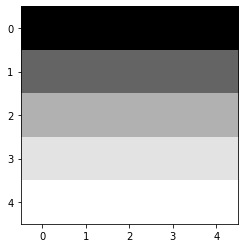

In [691]:
# flat_filters[10][0]-flat_filters[10][2]

plt.imshow(flat_filters[12][2], cmap='gray')

In [9]:
rotating_grids = rotating_klein_bottle_par(6,6,5,3,None,50)

In [10]:
rotating_grids.shape

(6, 6, 2, 3, 5, 5)

In [11]:
rotating_grids_flat = rotating_grids.reshape(-1, *rotating_grids.shape[-3:])

In [12]:
rotating_grids_flat.shape

(72, 3, 5, 5)

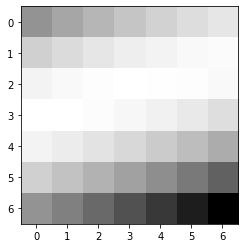

In [57]:
plt.imshow(all_filters[201][2],cmap='gray')

In [14]:
all_filters = np.concatenate([flat_filters, rotating_grids_flat],axis=0)

In [26]:
all_filters.shape

(320, 3, 7, 7)

In [5]:
mov_filters = moving_klein_bottle_par(6,6,7,3,None,50)

In [6]:
rot_filters = rotating_klein_bottle_par(6,6,7,3,None,50)

In [7]:
mov_filters = mov_filters.reshape(-1, *mov_filters.shape[-3:])
rot_filters= rot_filters.reshape(-1, *rot_filters.shape[-3:])

In [19]:
all_filters = np.concatenate([mov_filters, rot_filters],axis=0)
all_filters.shape

(180, 3, 7, 7)

In [20]:
# np.save('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_377_movAndRot180.npy',all_filters)

In [21]:
mov_filters = moving_klein_bottle_par(8,8,7,3,None,50)

In [22]:
rot_filters = rotating_klein_bottle_par(8,8,7,3,None,50)

In [23]:
mov_filters = mov_filters.reshape(-1, *mov_filters.shape[-3:])
rot_filters= rot_filters.reshape(-1, *rot_filters.shape[-3:])

In [24]:
all_filters = np.concatenate([mov_filters, rot_filters],axis=0)
all_filters.shape

(320, 3, 7, 7)

In [25]:
# np.save('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_377_movAndRot320.npy',all_filters)

In [15]:
# np.save('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_355_movandrot.npy',all_filters)
# filters = np.load('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_355_movandrot.npy', allow_pickle=True)

In [8]:
mov_filters = moving_klein_bottle_par(6,6,11,5,None,50)
rot_filters = rotating_klein_bottle_par(6,6,11,5,None,50)
mov_filters = mov_filters.reshape(-1, *mov_filters.shape[-3:])
rot_filters= rot_filters.reshape(-1, *rot_filters.shape[-3:])

In [9]:
all_filters = np.concatenate([mov_filters, rot_filters],axis=0)
all_filters.shape

(180, 5, 11, 11)

In [10]:
# np.save('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_511x11_movAndRot180.npy',all_filters)

In [13]:
mov_filters = moving_klein_bottle_par(4,4,5,5,None,50)
rot_filters = rotating_klein_bottle_par(4,4,5,5,None,50)
mov_filters = mov_filters.reshape(-1, *mov_filters.shape[-3:])
rot_filters= rot_filters.reshape(-1, *rot_filters.shape[-3:])

In [14]:
all_filters = np.concatenate([mov_filters, rot_filters],axis=0)
all_filters.shape

(80, 5, 5, 5)

In [15]:
# np.save('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_555_movAndRot80.npy',all_filters)

5


TypeError: 'int' object is not subscriptable

In [16]:
mov_filters = moving_klein_bottle_par(1,4,5,5,None,50)
rot_filters = rotating_klein_bottle_par(1,4,5,5,None,50)
mov_filters = mov_filters.reshape(-1, *mov_filters.shape[-3:])
rot_filters= rot_filters.reshape(-1, *rot_filters.shape[-3:])

In [17]:
all_filters = np.concatenate([mov_filters, rot_filters],axis=0)
all_filters.shape

(20, 5, 5, 5)

In [62]:
# np.save('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_555_movAndRot20.npy',all_filters)

In [63]:
mov_filters = moving_klein_bottle_par(1,4,3,3,None,50)
rot_filters = rotating_klein_bottle_par(1,4,3,3,None,50)
mov_filters = mov_filters.reshape(-1, *mov_filters.shape[-3:])
rot_filters= rot_filters.reshape(-1, *rot_filters.shape[-3:])
all_filters = np.concatenate([mov_filters, rot_filters],axis=0)
all_filters.shape

(20, 3, 3, 3)

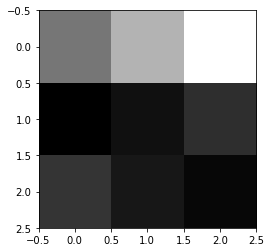

In [90]:
plt.imshow(all_filters[12,2],cmap='gray')

In [91]:
# np.save('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_333_movAndRot20.npy',all_filters)

In [108]:
mov_filters = moving_klein_bottle_par(4,4,11,5,None,50)
rot_filters = rotating_klein_bottle_par(4,4,11,5,None,50)
mov_filters = mov_filters.reshape(-1, *mov_filters.shape[-3:])
rot_filters= rot_filters.reshape(-1, *rot_filters.shape[-3:])
all_filters = np.concatenate([mov_filters, rot_filters],axis=0)
all_filters.shape

(80, 5, 11, 11)

In [109]:
# np.save('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_5x11x11_movAndRot80.npy',all_filters)

In [103]:
mov_filters = moving_klein_bottle_par(1,4,11,5,None,50)
mov_filters = mov_filters.reshape(-1, *mov_filters.shape[-3:])
mov_filters.shape

(12, 5, 11, 11)

In [105]:
# np.save('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_5x11x11_mov12.npy',mov_filters)

In [110]:
mov_filters = moving_klein_bottle_par(4,4,15,5,None,50)
rot_filters = rotating_klein_bottle_par(4,4,15,5,None,50)
mov_filters = mov_filters.reshape(-1, *mov_filters.shape[-3:])
rot_filters= rot_filters.reshape(-1, *rot_filters.shape[-3:])
all_filters = np.concatenate([mov_filters, rot_filters],axis=0)
all_filters.shape
# np.save('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_5x15x15_movAndRot80.npy',mov_filters)

In [111]:
mov_filters = moving_klein_bottle_par(4,4,9,5,None,50)
rot_filters = rotating_klein_bottle_par(4,4,9,5,None,50)
mov_filters = mov_filters.reshape(-1, *mov_filters.shape[-3:])
rot_filters= rot_filters.reshape(-1, *rot_filters.shape[-3:])
all_filters = np.concatenate([mov_filters, rot_filters],axis=0)
all_filters.shape
# np.save('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_5x9x9_movAndRot80.npy',mov_filters)

In [188]:
mov_filters = moving_klein_bottle_par(5,6,11,5,None,50)
rot_filters = rotating_klein_bottle_par(5,6,11,5,None,50)
mov_filters = mov_filters.reshape(-1, *mov_filters.shape[-3:])
rot_filters= rot_filters.reshape(-1, *rot_filters.shape[-3:])
all_filters = np.concatenate([mov_filters, rot_filters],axis=0)
all_filters.shape
# np.save('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_5x11x11_movAndRot150.npy',all_filters)

In [193]:
mov_filters = moving_klein_bottle_par(8,8,3,3,None,50)
rot_filters = rotating_klein_bottle_par(8,8,3,3,None,50)
mov_filters = mov_filters.reshape(-1, *mov_filters.shape[-3:])
rot_filters= rot_filters.reshape(-1, *rot_filters.shape[-3:])
all_filters = np.concatenate([mov_filters, rot_filters],axis=0)
all_filters.shape
# np.save('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_3x3x3_movAndRot320.npy',all_filters)

(320, 3, 3, 3)

In [175]:
mov_filters_f = moving_klein_bottle_par(2,4,11,5,None,50)
mov_filters_f = mov_filters_f.reshape(-1, *mov_filters_f.shape[-3:])
mov_filters = moving_klein_bottle_par(2,4,11,10,None,50)
mov_filters = mov_filters.reshape(-1, *mov_filters.shape[-3:])
mov_filters = mov_filters[:,tuple(range(0,mov_filters.shape[1],2)),:]

In [176]:
rot_filters_f = rotating_klein_bottle_par(2,4,11,5,None,50)
rot_filters_f = rot_filters_f.reshape(-1, *rot_filters_f.shape[-3:])
rot_filters = rotating_klein_bottle_par(2,4,11,10,None,50)
rot_filters = rot_filters.reshape(-1, *rot_filters.shape[-3:])
rot_filters = rot_filters[:,tuple(range(0,rot_filters.shape[1],2)),:]
all_filters = np.concatenate([mov_filters, mov_filters_f,rot_filters,rot_filters_f],axis=0)
all_filters.shape

(80, 5, 11, 11)

In [178]:
# np.save('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_5x11x11_movAndRot80_2speed.npy',all_filters)

In [ ]:
# f = open('/home/ephy/Projects/tda_convolve_video/src/python3/movingklein88-555.npy','rb')
# filters = np.load(f)
# filters_flat = filters.reshape(-1, *filters.shape[-3:])

In [ ]:
# # Go through and load videos as 3d volume arrays
# clips = np.unique(train['clip'])

# train_image = []
# # Grabbing just the first 5 frames!
# # for i in tqdm(range(1)):
# for i in tqdm(range(len(clips))):
#     stack = []
#     for imageName in train[train['clip']==clips[i]]['image'][0:6]:
# #         image = cv2.imread(datadir + 'altered/train_1/'+train['image'][i])
#         image = cv2.imread(datadir + 'altered/train_1/'+imageName)
#         image = Image.fromarray(image , 'RGB')
#         image = image.resize((100 , 100))
#         image = np.array(image)/255
#         image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
#         stack.append(image)
#     train_image.append(np.array(stack))

# train_image = np.array(train_image)

In [ ]:
# np.save('/home/ephy/Projects/tda_convolve_video/data/altered/vidStack100x100.npy',train_image)
train_image = np.load('/home/ephy/Projects/tda_convolve_video/data/altered/vidStack100x100.npy', allow_pickle=True)

In [ ]:
# target
y = np.array(train.drop_duplicates(subset=['clip'], keep='first')['class'])
# creating the training and validation set
X_train, X_test, y_train, y_test = train_test_split(np.stack(train_image), y, shuffle=True, random_state=1, test_size=0.2, stratify = y)

In [ ]:
# Check videos
# Note videos with low frame rate compared to movement speed...
# for i in range(6):
#     plt.imshow(X_train[9,i,...],cmap='gray')
#     plt.show()

# print(y_train[9])

In [ ]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [ ]:
a = np.array([1,1,1,2,3,3,2])
b = np.array(['a','a','a','b','c','c','b'])
u = np.unique(a)
l = [(b[np.where(a==entry)],a[np.where(a==entry)]) for entry in u]
last, l[0][0] = l[0][0][-1], l[0][0][:-1]
print(last,l)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 192, (3,5,5))
        self.conv2 = nn.Conv3d(192, 192, (3,5,5))
        self.conv3 = nn.Conv3d(192, 36, (1,5,5))
        
        x= torch.randn(1,100,100,6).view(-1,1,6,100,100)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 400)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, 101)
        
        self.batch1 = nn.BatchNorm1d(200)
        self.drop1 = nn.Dropout(p=0.15)
        
        
    def convs(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]*x[0].shape[3]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.batch1(x)
        x = self.drop1(x)
        x = self.fc3(x)
        return F.softmax(x, dim=1)

In [ ]:
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-5)
torch.cuda.memory_allocated()*1e-9

In [ ]:
# flat_filters = np.swapaxes(flat_filters,1,3)
# flat_filters = np.swapaxes(flat_filters,1,2)

In [ ]:
# Set filters in layer 2
# with torch.no_grad():
#     for i,weights in enumerate(flat_filters):
#         net.conv1.weight[i][0] = torch.nn.Parameter(torch.tensor(weights)).to(device)
#         for g,filts in enumerate(net.conv2.weight):
#             net.conv2.weight[i][g] = torch.nn.Parameter(torch.tensor(flat_filters[g])).to(device)

In [ ]:
# with torch.no_grad():
#     net.conv1.requires_grad=False
#     net.conv2.requires_grad=False

In [ ]:
## Check our work
# with torch.no_grad():
#     for i,weights in enumerate(flat_filters):
#         print(net.conv2.weight.shape)
#         plt.imshow(net.conv2.weight[i][9][0].cpu(), cmap='gray')
#         plt.show
#         break

In [ ]:
X_train = torch.tensor(X_train,dtype=torch.float32)
X_test =  torch.tensor(X_test,dtype=torch.float32)
y_train = torch.tensor(np.array(y_train),dtype=torch.float32)
y_test = torch.tensor(np.array(y_test),dtype=torch.float32)

In [ ]:
def test(net, X, y, batchSize):
    with torch.no_grad():
        correct = 0
        n = 0
#         for i in list(range(0,200, batchSize)):
        for i in list(range(0,X.shape[0], batchSize)):            
            data = X[i:i+batchSize].view(-1,1,6,100,100).to(device)
            out = torch.argmax(net(data),axis=1).cpu()
            correct += sum(out==torch.argmax(y[i:i+batchSize],axis=1))
            n +=1
        del data
        del out        
        return(float(correct)/(batchSize*n))

In [ ]:
batchSize=20
EPOCHS=40
results=[]
lossrec=[]
for EPOCH in range(EPOCHS):
    for i in range(0,X_train.shape[0],batchSize):
        X=X_train[i:i+batchSize].view(-1,1,6,100,100)
        X=X.to(device)
        y=y_train[i:i+batchSize]
        y=y.to(device)
        net.zero_grad()
        output = net(X)
        loss = nn.CrossEntropyLoss()(output, torch.argmax(y, axis=1))
        lossrec.append(loss.tolist())
        loss.backward()
        optimizer.step()
        del loss
        del output
        del X
        del y
        if (((i)%7000)==0) or ((EPOCH==(EPOCHS-1) and ((i)%1500)==0)):
            print(i,EPOCH)
            results.append(test(net, X_test, y_test, 20))

In [ ]:
np.save('/home/ephy/Projects/tda_convolve_video/data/altered/355_40E_normal_loss.npy',lossrec)
np.save('/home/ephy/Projects/tda_convolve_video/data/altered/355_40E_normal_results.npy',results)

In [ ]:
otherrecs = np.load('/home/ephy/Projects/tda_convolve_video/data/altered/1stLossRecs.npy')

In [ ]:
batchSize=20
EPOCHS=40
kf1_results=[]
kf1_lossrec=[]
for EPOCH in range(EPOCHS):
    for i in range(0,X_train.shape[0],batchSize):
        X=X_train[i:i+batchSize].view(-1,1,6,100,100)
        X=X.to(device)
        y=y_train[i:i+batchSize]
        y=y.to(device)
        net.zero_grad()
        output = net(X)
        loss = nn.CrossEntropyLoss()(output, torch.argmax(y, axis=1))
        kf1_lossrec.append(loss.tolist())
        loss.backward()
        optimizer.step()
        del loss
        del output
        del X
        del y
        if (((i+1)%6000)==0) or ((EPOCH==(EPOCHS-1) and ((i+1)%2000)==0)):
            print(i+1,EPOCH+1)
            kf1_results.append(test(net, X_test, y_test, 20))

In [ ]:
kf1_results

In [ ]:
plt.plot()

In [ ]:
test(net, X_test, y_test, 20)

In [ ]:
def ma(ts):
    moving_aves=[]
    for i in range(40,len(ts)-41,40):
        moving_aves.append(np.average(ts[i-4:i+5]))
    return(moving_aves)

In [ ]:
plt.plot(ma(otherrecs[0]), label='2 fixed')
plt.plot(ma(otherrecs[1]), label='1 fixed',alpha=.8)
plt.plot(ma(lossrec), label='From Scratch',alpha=.8)
plt.legend()

In [ ]:
# np.save('/home/ephy/Projects/tda_convolve_video/data/altered/1stLossRecs.npy',np.array([kf1_lossrec,kf_lossrec]))

In [ ]:
np.array([kf1_lossrec,kf_lossrec,lossrec])

In [ ]:
batchSize=20
EPOCHS=40
kf_results=[]
kf_lossrec=[]
for EPOCH in range(EPOCHS):
    for i in range(0,X_train.shape[0],batchSize):
        X=X_train[i:i+batchSize].view(-1,1,6,100,100)
        X=X.to(device)
        y=y_train[i:i+batchSize]
        y=y.to(device)
        net.zero_grad()
        output = net(X)
        loss = nn.CrossEntropyLoss()(output, torch.argmax(y, axis=1))
        kf_lossrec.append(loss.tolist())
        loss.backward()
        optimizer.step()
        del loss
        del output
        del X
        del y
        if (((i+1)%6000)==0) or ((EPOCH==(EPOCHS-1) and ((i+1)%2000)==0)):
            print(i+1,EPOCH+1)
            kf_results.append(test(net, X_test, y_test, 20))

In [ ]:
# BE CAREFUL!!!!! DON'T MESS WITH ANYTHING!!!!

In [ ]:
test(net, X_test, y_test, 20)

In [ ]:
plt.plot(kf_lossrec)

In [ ]:
print(test(net, X_test, y_test, 20))

In [ ]:
plt.plot(lossrec)

In [ ]:
# DO NOT RUN THE CELLS BELOW!

In [ ]:
print(test(net, X_test, y_test, 20))

In [ ]:
moving_aves=[]
for i in range(40,len(lossrec)-41,40):
    moving_aves.append(np.average(lossrec[i-4:i+5]))

In [ ]:
plt.plot(lossrec)
plt.show()
plt.plot(moving_aves)
plt.show()

In [ ]:
torch.cuda.empty_cache()
torch.cuda.memory_allocated()*1e-9

In [ ]:
len(list(range(0,X_train.shape[0],batchSize)))
# del net
# del optimizer

In [ ]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
print(target)
output.backward()
